In [ ]:
pip install transformers[torch] tokenizers datasets evaluate rouge_score sentencepiece huggingface_hub --upgrade

In [ ]:
import numpy as np

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments
from datasets import load_dataset

In [ ]:
ds = load_dataset("toughdata/quora-question-answer-dataset")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**BERT MODEL**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from transformers import pipeline

In [ ]:
question_answerer = pipeline(task="question-answering", model="distilbert-base-cased-distilled-squad")

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
context = """
Tea is an aromatic beverage prepared by pouring hot or boiling water over cured or fresh leaves of Camellia sinensis,
an evergreen shrub native to China and East Asia. After water, it is the most widely consumed drink in the world.
There are many different types of tea; some, like Chinese greens and Darjeeling, have a cooling, slightly bitter,
and astringent flavour, while others have vastly different profiles that include sweet, nutty, floral, or grassy
notes. Tea has a stimulating effect in humans primarily due to its caffeine content.

The tea plant originated in the region encompassing today's Southwest China, Tibet, north Myanmar and Northeast India,
where it was used as a medicinal drink by various ethnic groups. An early credible record of tea drinking dates to
the 3rd century AD, in a medical text written by Hua Tuo. It was popularised as a recreational drink during the
Chinese Tang dynasty, and tea drinking spread to other East Asian countries. Portuguese priests and merchants
introduced it to Europe during the 16th century. During the 17th century, drinking tea became fashionable among the
English, who started to plant tea on a large scale in India.

The term herbal tea refers to drinks not made from Camellia sinensis: infusions of fruit, leaves, or other plant
parts, such as steeps of rosehip, chamomile, or rooibos. These may be called tisanes or herbal infusions to prevent
confusion with 'tea' made from the tea plant.
"""

In [ ]:
result = question_answerer(question="Where is tea native to?", context=context)

print(result['answer'])

China and East Asia


In [ ]:
questions = ["Where is tea native to?",
             "When was tea discovered?",
             "What is the species name for tea?"]

results = question_answerer(question=questions, context=context)

for q, r in zip(questions, results):
    print(f"{q} \n>> {r['answer']}")

Where is tea native to? 
>> China and East Asia
When was tea discovered? 
>> 3rd century AD
What is the species name for tea? 
>> Camellia sinensis


In [ ]:
context = " "

In [ ]:
question = "What popular superheroes were introduced between 1939 and 1941?"

result = question_answerer(question=question, context=context)
print(result['answer'])

In [ ]:
questions = ["What popular superheroes were introduced between 1939 and 1941?",
             "What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?",
             "What comic book characters were created between 1939 and 1941?",
             "What well-known characters were created between 1939 and 1941?",
             "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"]

results = question_answerer(question=questions, context=context)

for q, r in zip(questions, results):
    print(f"{q} \n>> {r['answer']}")

What popular superheroes were introduced between 1939 and 1941? 
>> 
What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company? 
>> 
What comic book characters were created between 1939 and 1941? 
>> 
What well-known characters were created between 1939 and 1941? 
>> 
What well-known superheroes were introduced between 1939 and 1941 by Detective Comics? 
>> 


Since no BERT model works without context we cannot use BERT model here as our dataset is closed book ,i.e, questions answers without context.

**T5 MODEL**

In [ ]:
from transformers import T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Define max length of sequences in the tokenizer
tokenizer.model_max_length = 512

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
tokenizer.model_max_length = 512

In [46]:
type(ds['train'])

datasets.arrow_dataset.Dataset

In [ ]:
ds['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 45121
})

In [ ]:
ds['train'][0]["question"]

'Which is the best car brand in the world?'

In [ ]:
flattened_data = ds['train'].flatten()

In [ ]:
ds = ds['train'].train_test_split(test_size=0.2)

In [ ]:
prefix = "answer the question: "

# Define our preprocessing function
def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding = "max_length")

    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True, padding = "max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocessing function across our dataset
tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/36096 [00:00<?, ? examples/s]

Map:   0%|          | 0/9025 [00:00<?, ? examples/s]

In [76]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [78]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AutoTokenizer
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [53]:
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    fp16=True,
    predict_with_generate=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.420200,1.309250,0.037920,0.005965,0.031521,0.034578


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.420200,1.309250,0.037920,0.005965,0.031521,0.034578
2,1.430900,1.299604,0.090290,0.014876,0.075132,0.082333


TrainOutput(global_step=5642, training_loss=1.504652367463056, metrics={'train_runtime': 6030.8647, 'train_samples_per_second': 14.963, 'train_steps_per_second': 0.936, 'total_flos': 1.2213514848436224e+16, 'train_loss': 1.504652367463056, 'epoch': 2.0})

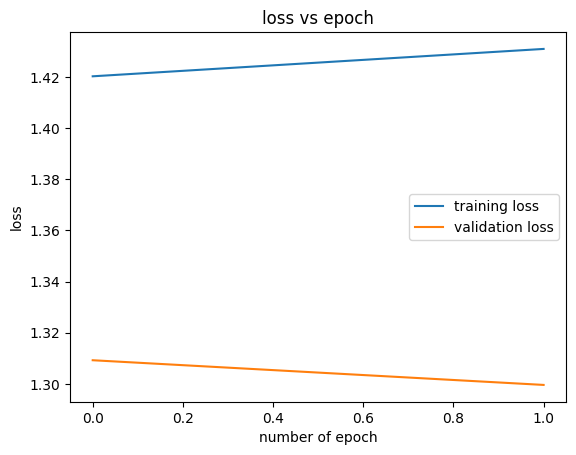

In [67]:
import matplotlib.pyplot as plt
plt.plot([1.420200,1.430900], label = 'training loss')
plt.plot([1.309250,1.299604], label = 'validation loss')
plt.xlabel("number of epoch")
plt.ylabel("loss")
plt.title("loss vs epoch")
plt.legend()
plt.show()


**FINDINGS**:
Since validation loss is less than training loss

**INFERENCE**: It implies that the model is not at all overfitting

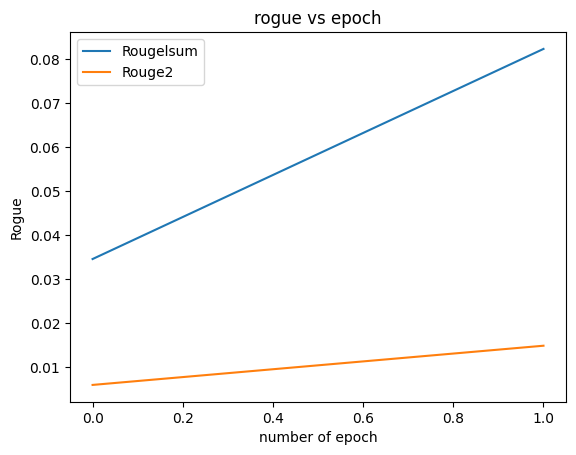

In [68]:
plt.plot([0.034578,0.082333], label = 'Rougelsum')
plt.plot([0.005965,0.014876], label = 'Rouge2')
plt.xlabel("number of epoch")
plt.ylabel("Rogue")
plt.title("rogue vs epoch")
plt.legend()
plt.show()

**FINDINGS:** Rogue score is increasing with every epoch in training which shows that fine tuning our model to the dataset is yielding positive results.

**INFERENCE**: T5 model works for closed book question-answering which means that T5 model is effectively trained on a universal context

**GPT MODEL**

In [ ]:
ds = ds['train'].train_test_split(test_size=0.2)

In [ ]:
training_data = []
validation_data = []
for data_point in ds['train']:
  training_data.append({'prompt':data_point['question'],'completion':data_point['answer']})
for data_point in ds['test']:
  validation_data.append({'prompt':data_point['question'],'completion':data_point['answer']})



In [ ]:
pip install --upgrade openai

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
  api_key='sk-None-azzsmlntTY8ZmWlXuM9nT3BlbkFJKSkIsPuTtf6i6gufuHeb',
)

In [ ]:
import json

training_file_name = "training_data.jsonl"
validation_file_name = "validation_data.jsonl"

def prepare_data(dictionary_data, final_file_name):
    with open(final_file_name, 'w') as outfile:
        for entry in dictionary_data:
        	json.dump(entry, outfile)
        	outfile.write('\n')

prepare_data(training_data, "training_data.jsonl")
prepare_data(validation_data, "validation_data.jsonl")

In [ ]:
training_file_id = client.files.create(
  file=open(training_file_name, "rb"),
  purpose="fine-tune"
)

validation_file_id = client.files.create(
  file=open(validation_file_name, "rb"),
  purpose="fine-tune"
)

print(f"Training File ID: {training_file_id}")
print(f"Validation File ID: {validation_file_id}")

Training File ID: FileObject(id='file-QXYP1d62ZgbbZd14CPFXvccN', bytes=49350199, created_at=1722349177, filename='training_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)
Validation File ID: FileObject(id='file-PCZTWiulmoHXju7XqE2drz2i', bytes=12525110, created_at=1722349179, filename='validation_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [45]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

model_GPT = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B')
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-1.3B')



In [49]:
prefix = "answer the question: "

# Define our preprocessing function
def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocessing function across our dataset
tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

In [52]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_GPT)

In [61]:
tokenizer.pad_token = tokenizer.eos_token
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    #labels = np.where(labels != -100, labels, tokenizer.eos_token)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

**CONCLUSION**: Transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a downstream task, has emerged as a powerful technique in natural language processing (NLP). T5, GPT uses an encoder decoder model whereas BERT uses an encoder only model.  Our findings show that encoder decoder model is able to answer questions without any context while only encoder model requires an external context. One may also say that encoder decoder model stores more information in its parameters than data itself.